# The script compares the output variables from standard Opensim offline workflow with the ones from the realtime calculations. This is done mainly by plotting ensemble curves and performing statistical analysis

In [2]:
from IPython import get_ipython
get_ipython().magic('reset -sf')
%matplotlib inline
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from numpy import array
import scipy

#import sys
#sys.path.insert(0, os.path.abspath('D:\LocalDisk\Research\Opensim\RealTime\Scripts'))
import readMotionFile
import visualize
#os.chdir('D:\LocalDisk\Research\Opensim\RealTime\\results_rt\\results_rt\\')
cwd=os.getcwd()
cwd


'C:\\Users\\user\\Documents\\GitHub\\Compare_rt'

# We are working with data from 3 km/h treadmill walking
## Load the variables from real time
**Import the csv file of the filtered joint angles (ja_rt)**

In [3]:
os.chdir(cwd+'/Data/results_rt_TR_4') # chanhe working directory
ja_rt = pd.read_csv('q_filtered.csv')

Capture the knee flexion angle and transform it in degrees

In [4]:
data_rad = ja_rt['knee_angle_r']
time = ja_rt['time']
#print(time)
data_degrees = (data_rad*180)/np.pi

Plot the knee angle as degrees

In [5]:
#plt.plot(time,data_rad)

**Now load the joint moments (jm_rt)**

In [6]:
#import opensim
#model = opensim.Model(cwd+'/Data/Esther_Hamn.osim')
#model.setUseVisualizer(True)
#state = model.initSystem()
#model.getVisualizer().show(state) # todo: run the IK solution in the visualizer


In [7]:
jm_rt = pd.read_csv('tau.csv')


Plot the knee moment

In [8]:
#plt.plot(time,jm_rt.knee_angle_r)


Load the static optimization force results (sof) and plot the glut_med force

In [9]:
sof_rt = pd.read_csv('so.csv')

In [10]:
#plt.plot(time,sof.glut_med1_r)

Load the joint reaction forces (jrf) results (sof) and plot the vertical hip contact force

In [11]:
jrf_rt = pd.read_csv('jr.csv')
#plt.plot(time,jrf.hip_r_on_femur_r_in_ground_fy*-1)


# Now we load the offline data

In [12]:
os.chdir(cwd+'/Data/Offline/')
header, labels, data = readMotionFile.read('TR_4_IK_Esther.mot')
index = labels.index('knee_angle_r')
ja_offline = pd.DataFrame(data,columns = labels)
data = ja_offline['knee_angle_r']
time = ja_offline['time']
#print(time)

Plot the knee angle

In [13]:
#plt.plot(time,data[:,index]*-1)

In [14]:
header, labels, data = readMotionFile.read('Esther_TR_4_JointReaction_ReactionLoads.sto')
jrf_offline = pd.DataFrame(data,columns=labels)



Plot the knee moment arm

In [15]:
#plt.plot(time,data[:,index])

In [31]:
header, labels, data = readMotionFile.read('TR_4_ID_Esther.sto')
jm_offline = pd.DataFrame(data,columns=labels)

# At this point we see that the time stamps of the two cases are very different to each other. Data are practically missing in the real time scenario, due to calculations lag. So we need some data interpolation techniques in order to perform statistical analysis later

In [32]:
time = ja_rt['time']
time = time.round(2) # convert float to integers and then round them to the second integer
#print(time)
#type(time)


In [42]:
ja_rt_append = ja_rt
jm_rt_append = jm_rt
jrf_rt_append = jrf_rt 


In [43]:
time = ja_rt_append['time']
tm1 = time.iloc[0]
tm2 = time.iloc[-1]
time = ja_offline['time']
time_list = time.values.tolist()
idx1 = time_list.index(tm1)
idx2 = time_list.index(tm2)
print(idx1,idx2)

(90, 1043)


In [44]:
length=len(ja_offline['time'][idx1:idx2])
length
idx2

1043

In [45]:
i=0
time = ja_rt['time']
time = time.round(2)
length=len(ja_offline['time'][idx1:idx2])
while len(time) <= int(length):
    
    for i in range(len(time)-1):
        diff = round(time[i+1]-time[i],2)
        if not diff == 0.01:
        #create dataframe to be appended
            rows_append = int(diff*100-1)
            data = np.empty((rows_append,ja_rt_append.shape[1],))
            data[:] = np.nan
            for k in np.arange(rows_append):
                data[k,0] = time[i]+0.01*k+0.01
            new_dataframe = pd.DataFrame(data,columns=ja_rt_append.columns)
            insertion_point = i
            a = ja_rt_append.iloc[:insertion_point+1]
            b = new_dataframe
            c = ja_rt_append.iloc[insertion_point+1:]
            ja_rt_append = pd.concat([a,b,c],ignore_index=True)
            a = jm_rt_append.iloc[:insertion_point+1]
            b = new_dataframe
            c = jm_rt_append.iloc[insertion_point+1:]
            jm_rt_append = pd.concat([a,b,c],ignore_index=True)
            a = jrf_rt_append.iloc[:insertion_point+1]
            b = new_dataframe
            c = jrf_rt_append.iloc[insertion_point+1:]
            jrf_rt_append = pd.concat([a,b,c],ignore_index=True)
        time = ja_rt_append['time']
        time = jrf_rt_append['time']
    
    


D:\LocalDisk\Programs\WinPython-64bit-2.7.10.3\python-2.7.10.amd64\lib\site-packages\ipykernel\__main__.py:29: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



# Interpolation techiques

In [47]:
pd.set_option('display.max_rows', ja_rt_append.shape[0]+1)


In [48]:
ja_rt_append_inter_lin = ja_rt_append.interpolate(axis=0)
jm_rt_append_inter_lin = jm_rt_append.interpolate(axis=0)
jrf_rt_append_inter_lin = jrf_rt_append.interpolate(axis=0)


In [49]:
ja_rt_append_inter_quad = ja_rt_append.interpolate(method ='quadratic',axis=0)
jm_rt_append_inter_quad = jm_rt_append.interpolate(method ='quadratic',axis=0)
jrf_rt_append_inter_quad = jrf_rt_append.interpolate(method ='quadratic',axis=0)

In [50]:
ja_rt_append_inter_poly = ja_rt_append.interpolate(method ='polynomial',order = 2,axis=0)
jm_rt_append_inter_poly = jm_rt_append.interpolate(method ='polynomial',order = 2,axis=0)
jrf_rt_append_inter_poly = jrf_rt_append.interpolate(method ='polynomial',order = 2,axis=0)

In [51]:
len((ja_offline['knee_angle_r'][idx1:idx2]*np.pi)/180)

953

# Plot the different interpolation techniques 

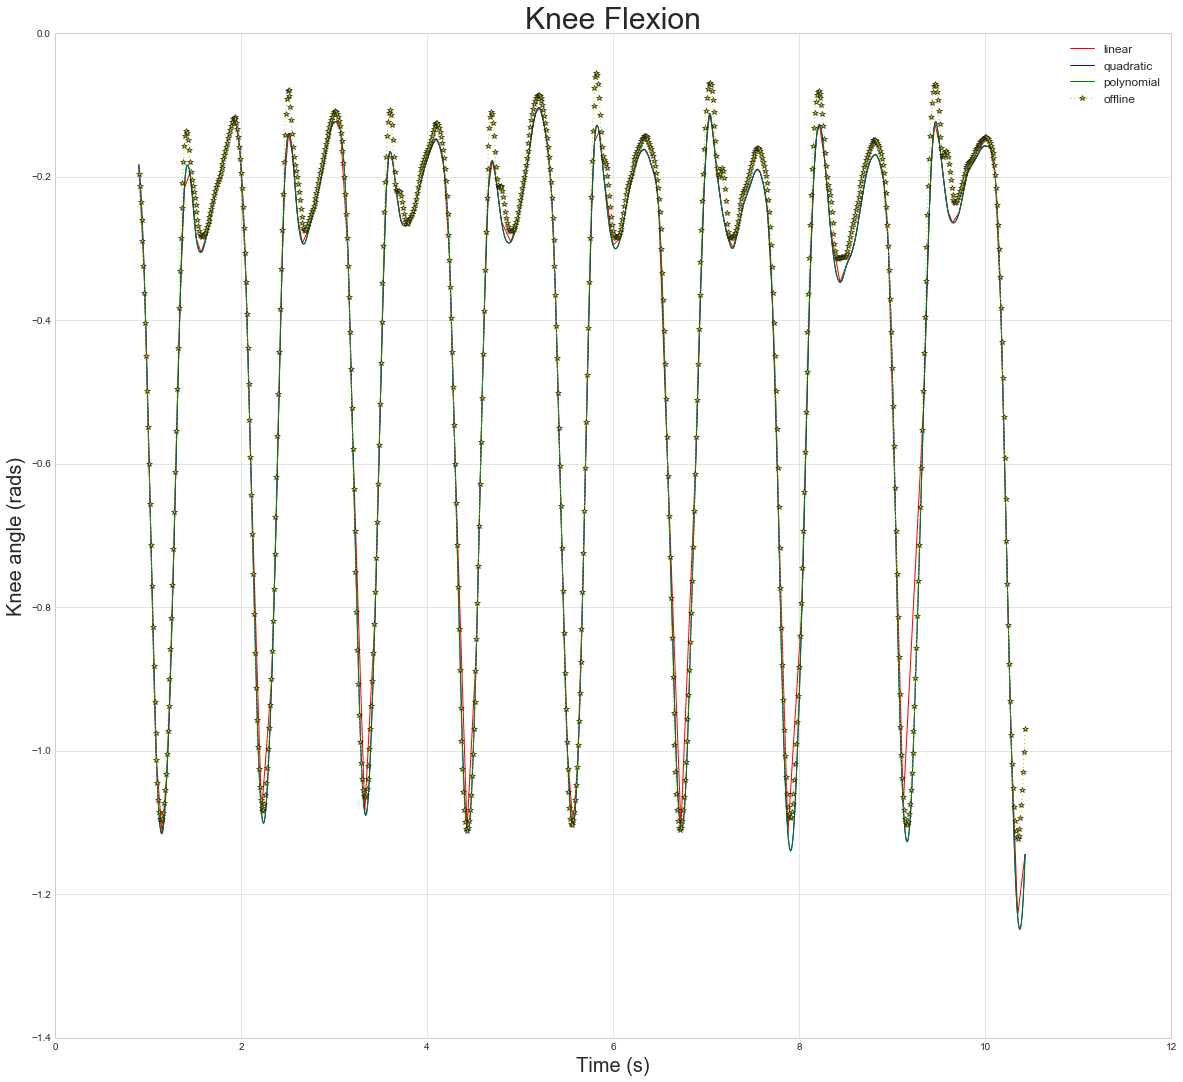

In [52]:
plt.style.use('seaborn-whitegrid')
plt.plot(ja_rt_append_inter_lin['time'],ja_rt_append_inter_lin['knee_angle_r'], 'r',label='linear') 
plt.plot(ja_rt_append_inter_quad['time'],ja_rt_append_inter_quad['knee_angle_r'], 'b',label = 'quadratic')   
plt.plot(ja_rt_append_inter_poly['time'],ja_rt_append_inter_poly['knee_angle_r'], 'g',label = 'polynomial')
plt.plot(ja_offline['time'][idx1:idx2+1],(ja_offline['knee_angle_r'][idx1:idx2+1]*np.pi)/180,':*y',label = 'offline')
plt.xlabel('Time (s)',fontsize=20)
plt.ylabel('Knee angle (rads)',fontsize=20)
plt.title('Knee Flexion',fontsize=30)
plt.legend()
plt.show()

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 18
plt.rcParams["figure.figsize"] = fig_size

# Conclusion: basic techniques have the same result
## we continue with the statistical comparison between the real time curves  and the offline data


# Loop through the gait cycles

# Average the offline data|

In [53]:
import scipy as sp
import scipy.interpolate

"""Calculate the resultant knee contact force in both offline data"""
kcf_res_r_offline = np.sqrt(jrf_offline.knee_r_on_tibia_r_in_ground_fx.pow(2)+jrf_offline.knee_r_on_tibia_r_in_ground_fy.pow(2)+\
                              jrf_offline.knee_r_on_tibia_r_in_ground_fz.pow(2))
kcf_res_l_offline = np.sqrt(jrf_offline.knee_l_on_tibia_l_in_ground_fx.pow(2)+jrf_offline.knee_l_on_tibia_l_in_ground_fy.pow(2)+\
                              jrf_offline.knee_l_on_tibia_l_in_ground_fz.pow(2))

"""Import the heelstrikes time stamps"""
events_file = pd.read_excel(cwd+'/Data/Offline/TR_3_heelstrikes.xls')
events_file = events_file.astype(np.double)*0.001

"""Right Leg"""
if events_file.rhs[0]<events_file.rto[0]:
    limit = events_file.shape[0]
else:
    limit = events_file.shape[0]-1
    
"""Loop between heelstrikes"""

for i in range(0,limit):
    
    """Find the indexes of the time stamps in the offline data"""
    time = ja_offline.time
    time = time.round(2)
    time_list = time.values.tolist()
    if events_file.rhs[0]<events_file.rto[0]:
        tm1 = events_file.rhs[i]
        tm2 = events_file.rto[i]
    else:
        tm1 = events_file.rhs[i]
        tm2 = events_file.rto[i+1]
        
    idx1 = time_list.index(tm1.round(2))
    idx2 = time_list.index(tm2.round(2))
    data = ja_offline.knee_angle_r[idx1:idx2+1]
    data2 = jm_offline.knee_angle_r_moment[idx1:idx2+1]
    data3 = kcf_res_r_offline[idx1:idx2+1]
    mat = np.array(data).reshape(len(data),1)
    mat2 = np.array(data2).reshape(len(data2),1)
    mat3 = np.array(data3).reshape(len(data3),1)
    # Interpolate the data using a quadratic spline to "new_length" samples
    """Knee angle"""
    new_length = 100
    x = np.array(range(0,len(data)))
    new_x = np.linspace(0, len(mat)-1, new_length)
    new_data = sp.interpolate.interp1d(x, mat, axis=0, kind='quadratic')(new_x)
    """Knee moment"""
    new_data2 = sp.interpolate.interp1d(x, mat2, axis=0, kind='quadratic')(new_x)
    """Knee resultant contact force"""
    new_data3 = sp.interpolate.interp1d(x, mat3, axis=0, kind='quadratic')(new_x)
    
    """Gather all stance phases in one array"""
     
    if i==0:
        knee_angle_r = new_data
        knee_moment_r = new_data2
        kcf_res_r = new_data3
    else:
        knee_angle_r = np.concatenate((knee_angle_r,new_data),axis=1)
        knee_moment_r = np.concatenate((knee_moment_r,new_data2),axis=1)
        kcf_res_r = np.concatenate((kcf_res_r,new_data3),axis=1)
        
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

"""Left Leg"""
if events_file.lhs[0]<events_file.lto[0]:
    limit = events_file.shape[0]
else:
    limit = events_file.shape[0]-1

for i in range(1,limit):
    
    """Find the indexes of the time stamps in the offline data"""
    time = ja_offline.time
    time = time.round(2)
    time_list = time.values.tolist()
    if events_file.lhs[0]<events_file.lto[0]:
        tm1 = events_file.lhs[i]
        tm2 = events_file.lto[i]
    else:
        tm1 = events_file.lhs[i]
        tm2 = events_file.lto[i+1]
        
    idx1 = time_list.index(tm1.round(2))
    idx2 = time_list.index(tm2.round(2))
    data = ja_offline.knee_angle_l[idx1:idx2+1]
    data2 = jm_offline.knee_angle_l_moment[idx1:idx2+1]
    data3 = kcf_res_l_offline[idx1:idx2+1]
    mat = np.array(data).reshape(len(data),1)
    mat2 = np.array(data2).reshape(len(data2),1)
    mat3 = np.array(data3).reshape(len(data3),1)
    # Interpolate the data using a quadratic spline to "new_length" samples
    """Knee angle"""
    new_length = 100
    x = np.array(range(0,len(data)))
    new_x = np.linspace(0, len(mat)-1, new_length)
    new_data = sp.interpolate.interp1d(x, mat, axis=0, kind='quadratic')(new_x)
    """Knee moment"""
    new_data2 = sp.interpolate.interp1d(x, mat2, axis=0, kind='quadratic')(new_x)
    """Knee resultant contact force"""
    new_data3 = sp.interpolate.interp1d(x, mat3, axis=0, kind='quadratic')(new_x)
    
    """Gather all stance phases in one array"""
     
    if i==1:
        knee_angle_l = new_data
        knee_moment_l = new_data2
        kcf_res_l = new_data3
    else:
        knee_angle_l = np.concatenate((knee_angle_l,new_data),axis=1)
        knee_moment_l = np.concatenate((knee_moment_l,new_data2),axis=1)
        kcf_res_l = np.concatenate((kcf_res_l,new_data3),axis=1)
"""Concatenate the two legs and average"""
knee_angle_offline = np.concatenate((knee_angle_r,knee_angle_l),axis=1)
knee_moment_offline = np.concatenate((knee_moment_r,knee_moment_l),axis=1)
kcf_res_offline = np.concatenate((kcf_res_r/585,kcf_res_l/585),axis=1)

# Real time data

In [54]:
"""Calculate the resultant knee contact force in real time data"""
kcf_res_r_rt = np.sqrt(jrf_rt_append_inter_poly.knee_r_on_tibia_r_in_ground_fx.pow(2)+jrf_rt_append_inter_poly.knee_r_on_tibia_r_in_ground_fy.pow(2)+\
                         jrf_rt_append_inter_poly.knee_r_on_tibia_r_in_ground_fz.pow(2))
kcf_res_l_rt = np.sqrt(jrf_rt_append_inter_poly.knee_l_on_tibia_l_in_ground_fx.pow(2)+jrf_rt_append_inter_poly.knee_l_on_tibia_l_in_ground_fy.pow(2)+\
                         jrf_rt_append_inter_poly.knee_l_on_tibia_l_in_ground_fz.pow(2))
knee_angle_l=[]
knee_angle_r=[]
knee_moment_l=[]
knee_moment_r=[]
kcf_res_r=[]
kcf_res_l=[]
"""Import the heelstrikes time stamps"""
events_file = pd.read_excel(cwd+'/Data/Offline/TR_3_heelstrikes.xls')
events_file = events_file.astype(np.double)*0.001

"""Right Leg"""
if events_file.rhs[0]<events_file.rto[0]:
    limit = events_file.shape[0]
else:
    limit = events_file.shape[0]-1
    
"""Loop between heelstrikes"""

for i in range(0,limit):
    
    """Find the indexes of the time stamps in the offline data"""
    time = ja_rt_append_inter_poly.time
    time = time.round(2)
    time_list = time.values.tolist()
    if events_file.rhs[0]<events_file.rto[0]:
        tm1 = events_file.rhs[i]
        tm2 = events_file.rto[i]
    else:
        tm1 = events_file.rhs[i]
        tm2 = events_file.rto[i+1]
    
        
    idx1 = time_list.index(tm1.round(2))
    idx2 = time_list.index(tm2.round(2))
    data = ja_rt_append_inter_poly.knee_angle_r[idx1:idx2+1]
    data2 = jm_rt_append_inter_poly.knee_angle_r[idx1:idx2+1]
    data3 = kcf_res_r_rt[idx1:idx2+1]
    mat = np.array(data).reshape(len(data),1)
    mat2 = np.array(data2).reshape(len(data2),1)
    mat3 = np.array(data3).reshape(len(data3),1)
    # Interpolate the data using a quadratic spline to "new_length" samples
    """Knee angle"""
    new_length = 100
    x = np.array(range(0,len(data)))
    new_x = np.linspace(0, len(mat)-1, new_length)
    new_data = sp.interpolate.interp1d(x, mat, axis=0, kind='quadratic')(new_x)
    """Knee moment"""
    new_data2 = sp.interpolate.interp1d(x, mat2, axis=0, kind='quadratic')(new_x)
    """Knee resultant contact force"""
    new_data3 = sp.interpolate.interp1d(x, mat3, axis=0, kind='quadratic')(new_x)
    
    """Gather all stance phases in one array"""
     
    if i==0:
        knee_angle_r = new_data
        knee_moment_r = new_data2
        kcf_res_r = new_data3
    else:
        knee_angle_r = np.concatenate((knee_angle_r,new_data),axis=1)
        knee_moment_r = np.concatenate((knee_moment_r,new_data2),axis=1)
        kcf_res_r = np.concatenate((kcf_res_r,new_data3),axis=1)
        
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""    
"""Left Leg"""
if events_file.lhs[0]<events_file.lto[0]:
    limit = events_file.shape[0]
else:
    limit = events_file.shape[0]-1

for i in range(1,limit):
    
    """Find the indexes of the time stamps in the realtime data"""
    time = ja_rt_append_inter_poly.time
    time = time.round(2)
    time_list = time.values.tolist()
    if events_file.lhs[0]<events_file.lto[0]:
        tm1 = events_file.lhs[i]
        tm2 = events_file.lto[i]
    else:
        tm1 = events_file.lhs[i]
        tm2 = events_file.lto[i+1]
        
    idx1 = time_list.index(tm1.round(2))
    idx2 = time_list.index(tm2.round(2))
    data = ja_rt_append_inter_poly.knee_angle_l[idx1:idx2+1]
    data2 = jm_rt_append_inter_poly.knee_angle_l[idx1:idx2+1]
    data3 = kcf_res_l_rt[idx1:idx2+1]
    mat = np.array(data).reshape(len(data),1)
    mat2 = np.array(data2).reshape(len(data2),1)
    mat3 = np.array(data3).reshape(len(data3),1)
    # Interpolate the data using a quadratic spline to "new_length" samples
    """Knee angle"""
    new_length = 100
    x = np.array(range(0,len(data)))
    new_x = np.linspace(0, len(mat)-1, new_length)
    new_data = sp.interpolate.interp1d(x, mat, axis=0, kind='quadratic')(new_x)
    """Knee moment"""
    new_data2 = sp.interpolate.interp1d(x, mat2, axis=0, kind='quadratic')(new_x)
    """Knee resultant contact force"""
    new_data3 = sp.interpolate.interp1d(x, mat3, axis=0, kind='quadratic')(new_x)
    
    """Gather all stance phases in one array"""
     
    if i==1:
        knee_angle_l = new_data
        knee_moment_l = new_data2
        kcf_res_l = new_data3
    else:
        knee_angle_l = np.concatenate((knee_angle_l,new_data),axis=1)
        knee_moment_l = np.concatenate((knee_moment_l,new_data2),axis=1)
        kcf_res_l = np.concatenate((kcf_res_l,new_data3),axis=1)
"""Concatenate the two legs and average"""
knee_angle_rt = np.concatenate((knee_angle_r*180/np.pi,knee_angle_l*180/np.pi),axis=1)
knee_moment_rt = np.concatenate((knee_moment_r,knee_moment_l),axis=1)
kcf_res_rt = np.concatenate((kcf_res_r/585,kcf_res_l/585),axis=1)

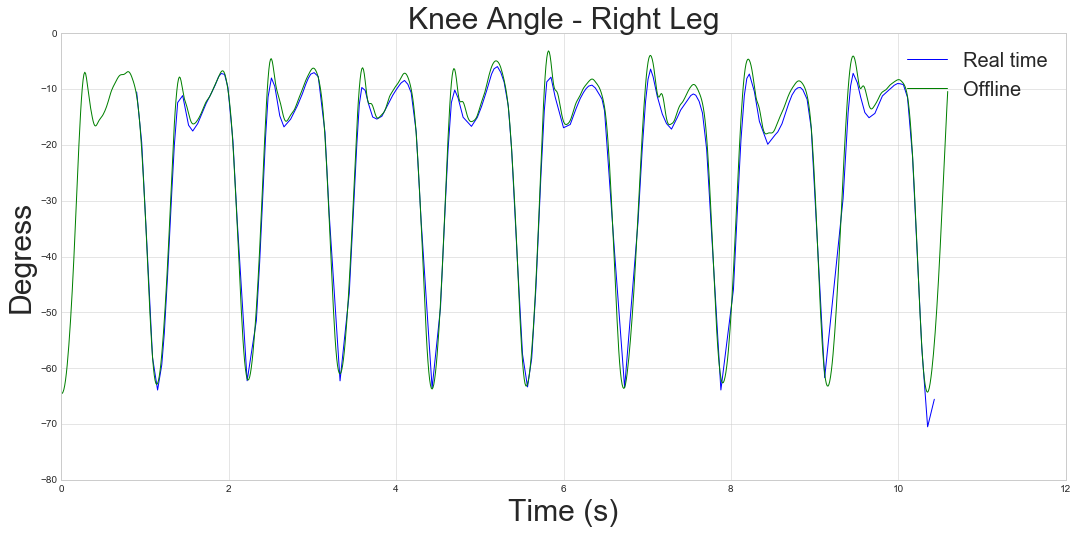

In [55]:
fig = plt.figure(figsize=(18, 8))
plt.plot(ja_rt_append_inter_poly.time,(ja_rt_append_inter_lin.knee_angle_r*180)/np.pi)
plt.plot(ja_offline.time,ja_offline.knee_angle_r)
plt.legend(['Real time','Offline'],fontsize = 20)
plt.title('Knee Angle - Right Leg',fontsize = 30)
plt.ylabel('Degress',fontsize = 30)
plt.xlabel('Time (s)',fontsize = 30)
plt.show()
fig.savefig('Knee Angle-Right Leg', dpi=100)

In [91]:
X = knee_angle_rt.mean(axis=1)
X_std = knee_angle_rt.std(axis=1)
Y = knee_angle_offline.mean(axis=1)
Y_std = knee_angle_offline.std(axis=1)

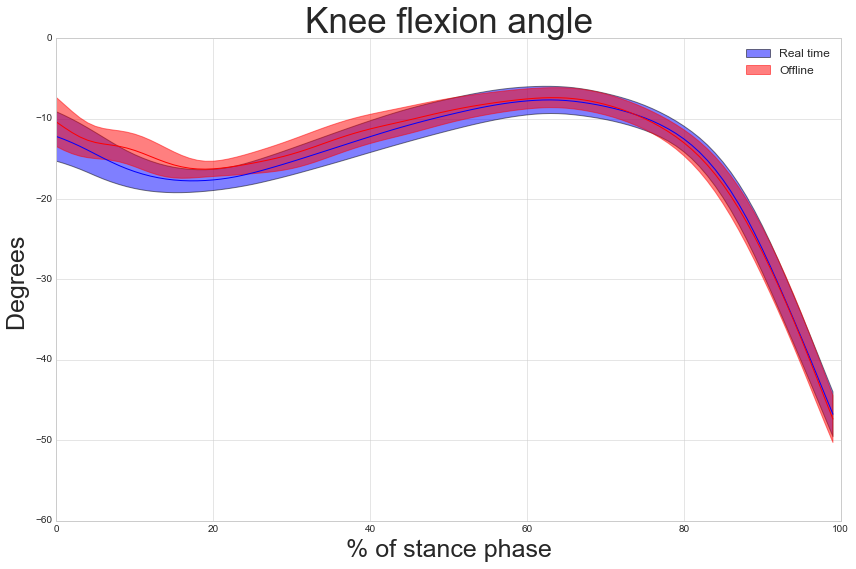

In [92]:
fig = plt.figure(figsize=(12, 8))
plt.plot(range(0,100),X)
plt.plot(range(0,100),Y,'r')
plt.fill_between(range(0,100),X-X_std,X+X_std,alpha=0.5,label = 'Real time')
plt.fill_between(range(0,100),Y-Y_std,Y+Y_std,alpha=0.5,color='r',label = 'Offline')
plt.title('Knee flexion angle',fontsize=35)
plt.ylabel('Degrees ',fontsize=25)
plt.xlabel('% of stance phase',fontsize=25)
plt.tight_layout()
plt.legend()
plt.show()
fig.savefig('Average Knee Angles.jpg', dpi=100)

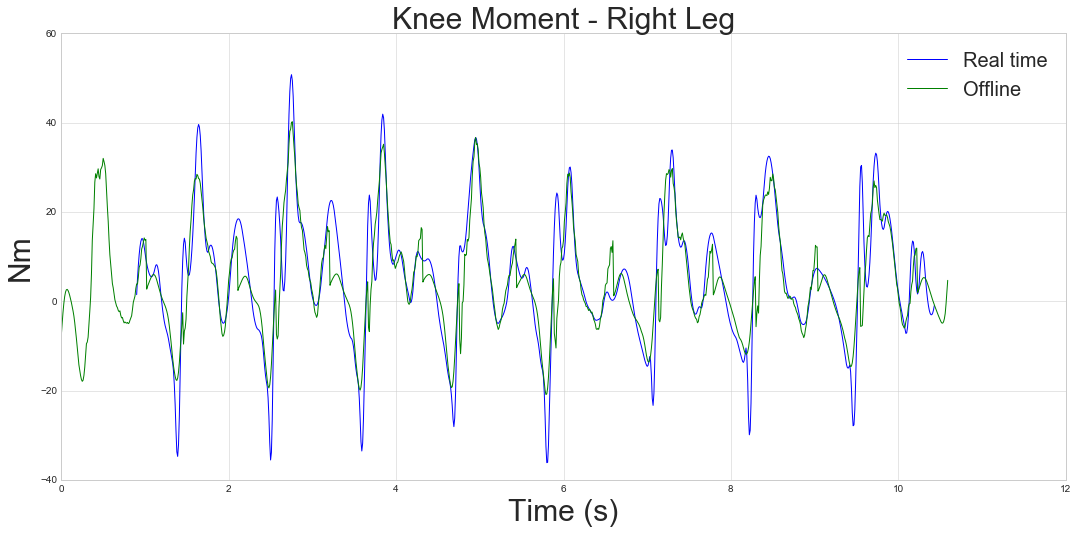

In [58]:
fig = plt.figure(figsize=(18, 8))
plt.plot(jm_rt_append_inter_poly.time,jm_rt_append_inter_poly.knee_angle_r)
plt.plot(jm_offline.time,jm_offline.knee_angle_r_moment)
plt.legend(['Real time','Offline'],fontsize = 20)
plt.title('Knee Moment - Right Leg',fontsize = 30)
plt.ylabel('Nm',fontsize = 30)
plt.xlabel('Time (s)',fontsize = 30)
plt.show()
fig.savefig('Knee Moment-Right Leg', dpi=100)

In [93]:
X = knee_moment_rt.mean(axis=1)
X_std = knee_moment_rt.std(axis=1)
Y = knee_moment_offline.mean(axis=1)
Y_std = knee_moment_offline.std(axis=1)

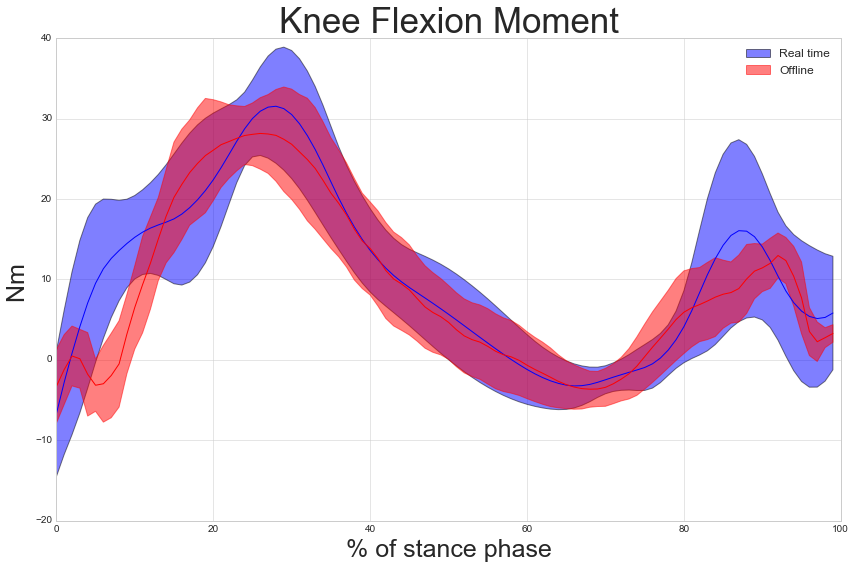

In [94]:
fig = plt.figure(figsize=(12, 8))
plt.plot(range(0,100),X)
plt.plot(range(0,100),Y,'r')
plt.fill_between(range(0,100),X-X_std,X+X_std,alpha=0.5,label='Real time')
plt.fill_between(range(0,100),Y-Y_std,Y+Y_std,alpha=0.5,color='r',label = 'Offline')
plt.title('Knee Flexion Moment',fontsize=35)
plt.ylabel('Nm ',fontsize=25)
plt.xlabel('% of stance phase',fontsize=25)
plt.tight_layout()
plt.legend()
plt.show()
fig.savefig('Average Knee Moments.jpg', dpi=100)

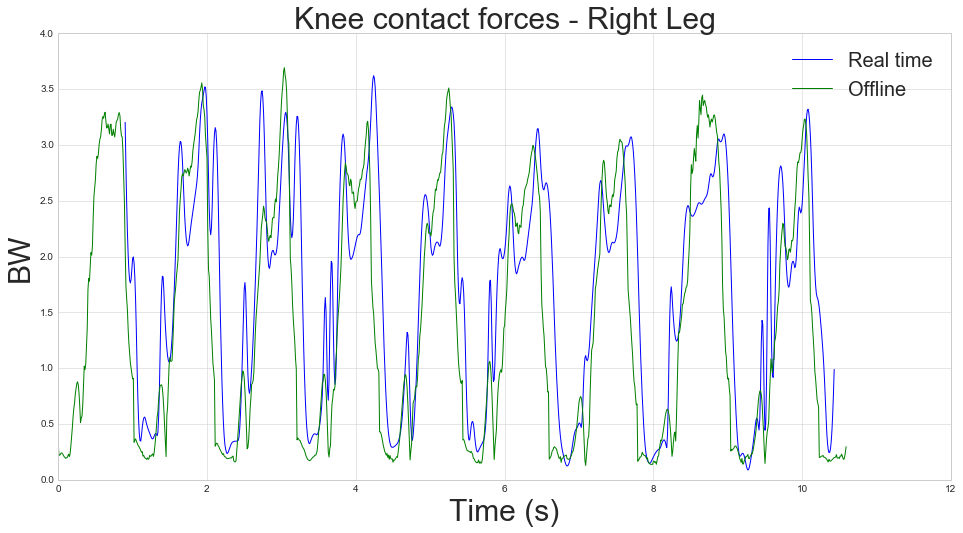

In [61]:
fig = plt.figure(figsize=(16, 8))
plt.plot(jrf_rt_append_inter_lin['time'],kcf_res_r_rt/585)
plt.plot(jrf_offline.time,kcf_res_r_offline/585)
plt.legend(['Real time','Offline'],fontsize = 20)
plt.title('Knee contact forces - Right Leg',fontsize = 30)
plt.ylabel('BW',fontsize = 30)
plt.xlabel('Time (s)',fontsize = 30)
plt.show()
fig.savefig('Knee contact forces-Right Leg', dpi=100)

In [95]:
X = kcf_res_rt.mean(axis=1)
X_std = kcf_res_rt.std(axis=1)
Y = kcf_res_offline.mean(axis=1)
Y_std = kcf_res_offline.std(axis=1)

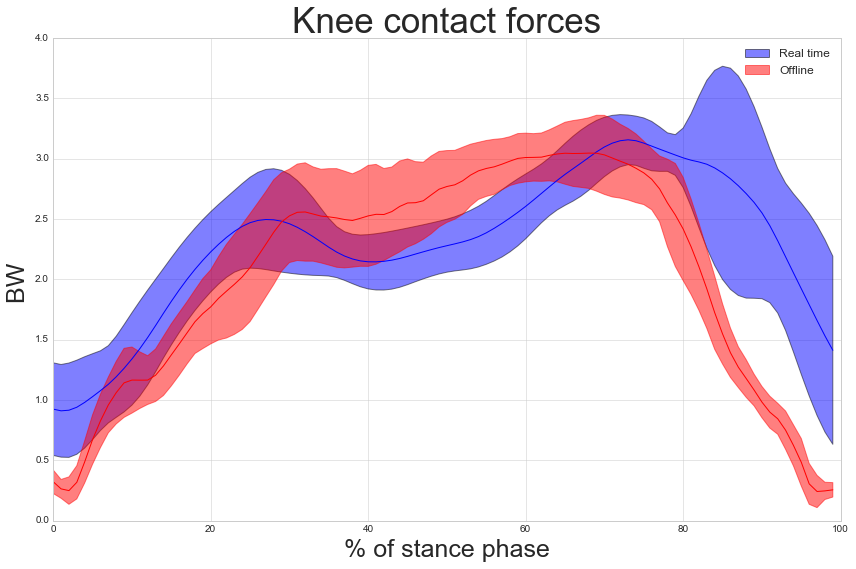

In [96]:
fig = plt.figure(figsize=(12, 8))
plt.plot(range(0,100),X)
plt.plot(range(0,100),Y,'r')
plt.fill_between(range(0,100),X-X_std,X+X_std,alpha=0.5,label = 'Real time')
plt.fill_between(range(0,100),Y-Y_std,Y+Y_std,alpha=0.5,color='r',label='Offline')
plt.title('Knee contact forces',fontsize=35)
plt.ylabel('BW ',fontsize=25)
plt.xlabel('% of stance phase',fontsize=25)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('Average Knee contact forces.jpg', dpi=100)

In [88]:
"""Ordinary Least squares"""
import statsmodels.api as sm
scores=[]
pvalues=[]
for i in range(0,kcf_res_offline.shape[1]):
    array1 = kcf_res_offline[:,i]
    array2 = kcf_res_rt[:,i]    
    X = array1
    X = X.reshape(len(X),1)
    X = sm.add_constant(X)
    Y = array2
    Y = Y.reshape(len(Y),1)
    model = sm.OLS(Y, X)
    results = model.fit()
    scores.append(results.rsquared)
    pvalues.append(results.f_pvalue)
    print('R-squared = {} and p-value = {}'.format(results.rsquared,results.f_pvalue))
          
print('{} plus/min {}'.format(np.mean(scores),np.std(scores)))

R-squared = 0.293337741151 and p-value = 5.92939713884e-09
R-squared = 0.261942846004 and p-value = 5.26060496548e-08
R-squared = 0.0642417363057 and p-value = 0.0109458734134
R-squared = 0.670842609483 and p-value = 2.20079597355e-25
R-squared = 0.169836123608 and p-value = 2.04215883261e-05
R-squared = 0.179681851098 and p-value = 1.10946476811e-05
R-squared = 0.299670024863 and p-value = 3.77663132388e-09
R-squared = 0.349603369068 and p-value = 9.36323327473e-11
R-squared = 0.642847763765 and p-value = 1.22630766462e-23
R-squared = 0.296765571113 and p-value = 4.64691529429e-09
R-squared = 0.843760853384 and p-value = 2.73534388467e-41
R-squared = 0.793165530942 and p-value = 2.62987263791e-35
R-squared = 0.221248375522 and p-value = 7.89182286348e-07
R-squared = 0.820012773076 and p-value = 2.84579264986e-38
0.421925512099 plus/min 0.260961855463


In [89]:
"""Stats linear Regression"""
from scipy import stats
scores=[]
for i in range(0,kcf_res_offline.shape[1]):
    array1 = kcf_res_offline[:,i]
    array2 = kcf_res_rt[:,i]    
    X = array1
    #X = X.reshape(len(X),1)
    Y = array2
    #Y = Y.reshape(len(Y),1)
    slope, intercept, r_value, p_value, std_err = stats.linregress(X,Y)
    scores.append(r_value)
    print('R-squared = {} and p = {}'.format(r_value,p_value))
print('{} plus/min {}'.format(np.mean(scores),np.std(scores)))

R-squared = 0.54160662953 and p = 5.92939713884e-09
R-squared = 0.511803522852 and p = 5.26060496548e-08
R-squared = 0.253459535835 and p = 0.0109458734134
R-squared = 0.819049821124 and p = 2.20079597355e-25
R-squared = 0.41211178533 and p = 2.04215883261e-05
R-squared = 0.423888960811 and p = 1.10946476811e-05
R-squared = 0.547421249919 and p = 3.77663132388e-09
R-squared = 0.591272668968 and p = 9.36323327473e-11
R-squared = 0.801777876824 and p = 1.22630766462e-23
R-squared = 0.544761939854 and p = 4.64691529429e-09
R-squared = 0.918564561358 and p = 2.73534388467e-41
R-squared = 0.890598411711 and p = 2.62987263791e-35
R-squared = 0.470370466252 and p = 7.89182286348e-07
R-squared = 0.905545566538 and p = 2.84579264986e-38
0.616588071208 plus/min 0.204315106008


In [87]:
intercept

0.8079475710899067

In [76]:
"""Scikit Linear Regression"""
scores=[]
for i in range(0,kcf_res_offline.shape[1]):
    array1 = kcf_res_offline[:,i]
    array2 = kcf_res_rt[:,i]    
    lm = linear_model.LinearRegression()
    X = array1
    X = X.reshape(len(X),1)
    Y = array2
    Y = Y.reshape(len(Y),1)
    model = lm.fit(X,Y)
    scores.append(model.score(X,Y))
    print('R-squared = {}'.format(model.score(X,Y)))
np.mean(scores)

R-squared = 0.293337741151
R-squared = 0.261942846004
R-squared = 0.0642417363057
R-squared = 0.670842609483
R-squared = 0.169836123608
R-squared = 0.179681851098
R-squared = 0.299670024863
R-squared = 0.349603369068
R-squared = 0.642847763765
R-squared = 0.296765571113
R-squared = 0.843760853384
R-squared = 0.793165530942
R-squared = 0.221248375522
R-squared = 0.820012773076


0.42192551209875145

In [ ]:
import statsmodels.api as sm
scores=[]
pvalues=[]
for i in range(0,knee_moment_offline.shape[1]):
    array1 = knee_moment_offline[:,i]
    array2 = knee_moment_rt[:,i]    
    X = array1
    X = X.reshape(len(X),1)
    Y = array2
    Y = Y.reshape(len(Y),1)
    model = sm.OLS(Y, X).fit()
    scores.append(float(model.summary().tables[0][0][3].data))
    pvalues.append(model.summary().tables[1][1][4])
    print('R-squared = {} and p-value = {}'.format(model.summary().tables[0][0][3],model.summary().tables[1][1][4]))
          
print('{} plus/min {}'.format(np.mean(scores),np.std(scores)))

In [67]:
import statsmodels.api as sm
scores=[]
pvalues=[]
for i in range(0,kcf_res_offline.shape[1]):
    array1 = kcf_res_offline[:,i]
    array2 = kcf_res_rt[:,i]    
    X = array1
    X = X.reshape(len(X),1)
    Y = array2
    Y = Y.reshape(len(Y),1)
    model = sm.OLS(Y,X).fit()
    scores.append(float(model.summary().tables[0][0][3].data))
    pvalues.append(model.summary().tables[1][1][4])
    #plt.scatter(array1,array2)
    #plt.plot(array1)
    #plt.show()
    #raw_input("Press Enter to continue...")
    print('R-squared = {} and p-value = {}'.format(model.summary().tables[0][0][3],model.summary().tables[1][1][4]))
          
print('{} plus/min {}'.format(np.mean(scores),np.std(scores)))

R-squared =    0.863 and p-value =  0.000
R-squared =    0.854 and p-value =  0.000
R-squared =    0.826 and p-value =  0.000
R-squared =    0.925 and p-value =  0.000
R-squared =    0.854 and p-value =  0.000
R-squared =    0.851 and p-value =  0.000
R-squared =    0.879 and p-value =  0.000
R-squared =    0.901 and p-value =  0.000
R-squared =    0.944 and p-value =  0.000
R-squared =    0.855 and p-value =  0.000
R-squared =    0.967 and p-value =  0.000
R-squared =    0.962 and p-value =  0.000
R-squared =    0.828 and p-value =  0.000
R-squared =    0.967 and p-value =  0.000
0.891142857143 plus/min 0.0502946420646


In [ ]:
plt.plot(array2)
plt.plot(array1)

In [71]:
stats.linregress(X,Y)

ValueError: too many values to unpack

In [69]:
scores=[]
for i in range(0,knee_moment_offline.shape[1]):
    array1 = knee_moment_offline[:,i]
    array2 = knee_moment_rt[:,i]    
    lm = linear_model.LinearRegression()
    X = array1
    X = X.reshape(len(X),1)
    Y = array2
    Y = Y.reshape(len(Y),1)
    model = lm.fit(X,Y)
    scores.append(model.score(X,Y))
    print('R-squared = {}'.format(model.score(X,Y)))
print('{} plus/min {}'.format(np.mean(scores),np.std(scores)))

R-squared = 0.65202703414
R-squared = 0.530126179435
R-squared = 0.51529470157
R-squared = 0.81676029668
R-squared = 0.417135139899
R-squared = 0.530318456104
R-squared = 0.726247473153
R-squared = 0.764171346483
R-squared = 0.883307726308
R-squared = 0.782410050041
R-squared = 0.787630190951
R-squared = 0.941027420928
R-squared = 0.513828457828
R-squared = 0.817765504835
0.691289284168 plus/min 0.157242186639


In [ ]:
scores